# Fake Image Detection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

sns.set(style='white', context='notebook', palette='deep')

## Initial preparation

In [4]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

#### Functions

In [5]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

In [7]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

## Data preparation

### Read dataset and conversion to ELA

In [8]:
dataset = pd.read_csv('dataset.csv')

In [9]:
X = []
Y = []

In [10]:
for index, row in dataset.iterrows():
    X.append(array(convert_to_ela_image(row[0], 90).resize((128, 128))).flatten() / 255.0)
    Y.append(row[1])

C:\Users\ykraj\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ykraj\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ykraj\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ykraj\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag))


### Normalization

In [11]:
X = np.array(X)
Y = to_categorical(Y, 2)

### Reshape X

In [12]:
X = X.reshape(-1, 128, 128, 3)

## Train-test split

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

## CNN building

In [14]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Input:  (None, 128, 128, 3)
Output:  (None, 124, 124, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 120, 120, 32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Input:  (None, 128, 128, 3)
Output:  (None, 60, 60, 32)


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               29491456  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

### Add optimizer

In [16]:
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)

In [17]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### Define early stopping

In [18]:
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

### Model training

In [19]:
epochs = 30
batch_size = 100

In [20]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Train on 7533 samples, validate on 1884 samples
Epoch 1/30
 - 200s - loss: 0.4518 - acc: 0.7843 - val_loss: 0.2642 - val_acc: 0.8487
Epoch 2/30
 - 194s - loss: 0.3043 - acc: 0.8647 - val_loss: 0.2357 - val_acc: 0.9066
Epoch 3/30
 - 163s - loss: 0.2526 - acc: 0.8925 - val_loss: 0.2698 - val_acc: 0.9013
Epoch 4/30
 - 180s - loss: 0.1974 - acc: 0.9178 - val_loss: 0.1721 - val_acc: 0.9236
Epoch 5/30
 - 202s - loss: 0.1808 - acc: 0.9253 - val_loss: 0.1519 - val_acc: 0.9342
Epoch 6/30
 - 185s - loss: 0.1589 - acc: 0.9335 - val_loss: 0.2328 - val_acc: 0.9151
Epoch 7/30
 - 203s - loss: 0.1479 - acc: 0.9413 - val_loss: 0.1353 - val_acc: 0.9411
Epoch 8/30
 - 203s - loss: 0.1232 - acc: 0.9549 - val_loss: 0.1816 - val_acc: 0.9289
Epoch 9/30
 - 202s - loss: 0.1057 - acc: 0.9618 - val_loss: 0.1315 - val_acc: 0.9464
Epoch 10/30
 - 202s - loss: 0.1028 - acc: 0.9635 - val_loss: 0.1390 - val_acc: 0.9512
Epoch 11/30
 - 202s - loss: 0.0788 - acc: 0.9745 - va

## Performance measure

### Accuracy and loss curves during training-validation

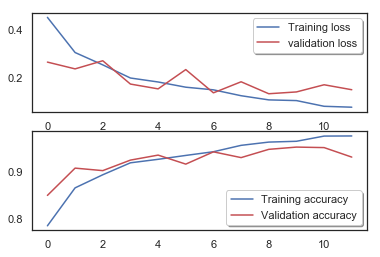

In [21]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion matrix

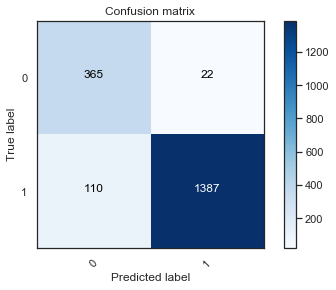

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [31]:
a =array(convert_to_ela_image('./casia-dataset/CASIA2/Au/Au_ani_00001.jpg', 90).resize((128, 128))).flatten() / 255.0

In [32]:
feature = a.reshape(-1, 128, 128, 3)

In [33]:
print(feature)

[[[[0.05882353 0.05882353 0.        ]
   [0.05882353 0.         0.12156863]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.12156863 0.         0.05882353]
   [0.         0.         0.        ]]

  [[0.         0.05882353 0.12156863]
   [0.         0.         0.12156863]
   [0.         0.         0.        ]
   ...
   [0.05882353 0.05882353 0.05882353]
   [0.05882353 0.05882353 0.05882353]
   [0.         0.         0.        ]]

  [[0.12156863 0.05882353 0.        ]
   [0.12156863 0.05882353 0.        ]
   [0.         0.         0.        ]
   ...
   [0.05882353 0.05882353 0.05882353]
   [0.05882353 0.05882353 0.18431373]
   [0.         0.         0.12156863]]

  ...

  [[0.         0.05882353 0.05882353]
   [0.         0.05882353 0.05882353]
   [0.12156863 0.05882353 0.18431373]
   ...
   [0.12156863 0.12156863 0.12156863]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

In [34]:
a = model.predict(feature)[0]

In [35]:
#0-fake 1-real
print(a)

[0.00108855 0.9989115 ]


In [36]:
if(a[1]>a[0]):
    print("REAL")
else:
    print("FAKE")

REAL


In [23]:
model.save('model/my_model.h5')

In [26]:
print(history.history['acc'])

[0.7842824858972217, 0.8647285302163563, 0.8924731224573547, 0.9178282246320003, 0.9252621816572845, 0.9334926346565929, 0.9413248395343772, 0.9548652638054046, 0.9617682246435184, 0.9634939670309545, 0.9745121574110677, 0.9747776564224995]
